In [74]:
import pandas as pd
import numpy as np
import datetime as dt
from pylab import mpl, plt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'arial'
np.random.seed(1000)
np.set_printoptions(suppress=True, precision=4)
%matplotlib inline


import seaborn as sns
import custom_functions as cf
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, roc_curve

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error,  
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from collections import Counter

## Testing timeline chart

In [102]:
banks_data = {'2009Q4': {'Actual failed': 15, 'Predicted failed': 0},
              '2010Q1': {'Actual failed': 20, 'Predicted failed': 0},
              '2010Q2': {'Actual failed': 22, 'Predicted failed': 0},
              '2010Q3': {'Actual failed': 41, 'Predicted failed': 0},
              '2010Q4': {'Actual failed': 40, 'Predicted failed':33},
              '2010Q4': {'Actual failed': 40, 'Predicted failed':35},
              '2010Q4': {'Actual failed': 40, 'Predicted failed':43},
              '2011Q1': {'Actual failed': 37, 'Predicted failed':30},
              '2011Q2': {'Actual failed': 44, 'Predicted failed':37},
              '2011Q3': {'Actual failed': 44, 'Predicted failed':50}
             }

In [107]:
df = pd.DataFrame.from_dict(banks_data, orient='index')
df['Assets lost'] = [100, 120, 200, 400, 1000, 5000, 10000, 12000]
df

,Actual failed,Predicted failed,Assets lost
2009Q4,15,0,100
2010Q1,20,0,120
2010Q2,22,0,200
2010Q3,41,0,400
2010Q4,40,43,1000
2011Q1,37,30,5000
2011Q2,44,37,10000
2011Q3,44,50,12000


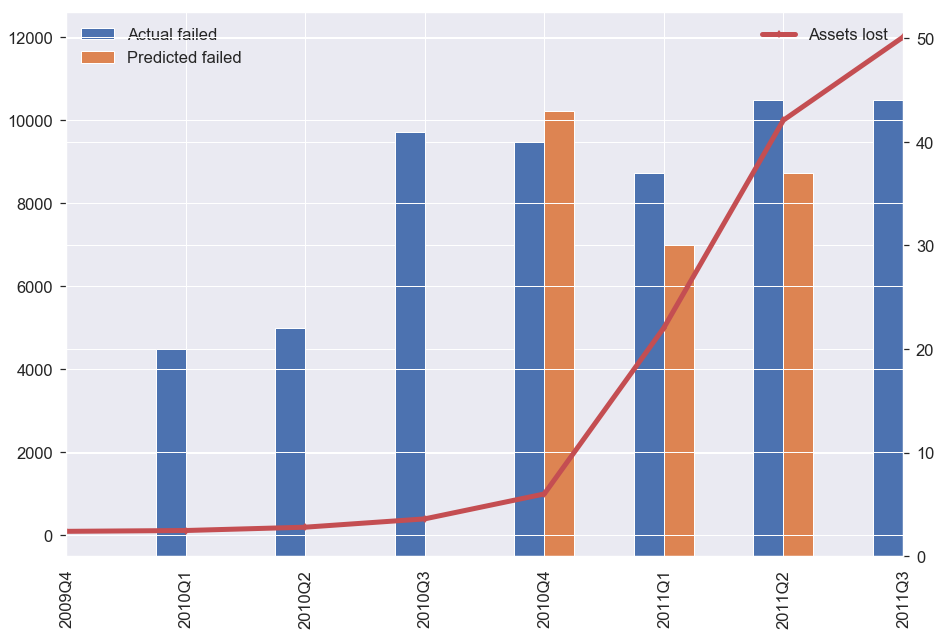

In [165]:

sns.set(font_scale=1.5)
fig, ax1 = plt.subplots(sharex=True, figsize=(15, 10))
ax2 = ax1.twinx()
df[['Actual failed', 'Predicted failed']].plot(ax=ax1, kind='bar').legend(loc='upper left')
df['Assets lost'].plot(ax=ax2, kind='line', linewidth=5, style='r', marker='d').legend(loc='upper right')
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
plt.show()


## Load and inspect data set from 2010-Q3

In [48]:
camel_insample = pd.read_csv('data/camel_data_after2010Q3.csv', index_col = 0)
len(camel_insample.index)

7020

In [49]:
camel_model_set = camel_insample.dropna()
len(camel_model_set)

7014

In [50]:
len(camel_model_set.loc[camel_model_set.Target == 1])

137

In [51]:
X = camel_model_set.drop(columns=['AsOfDate', 'Target'])
# Standardizing the features for PCS
X_pca_std = StandardScaler().fit_transform(X)

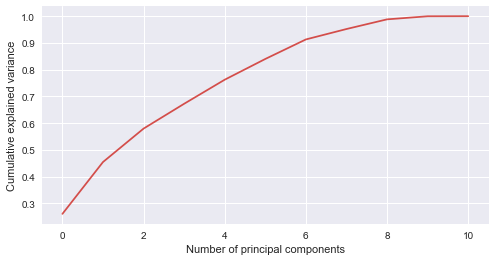

In [52]:
# Run PCA and plot explained variance
pca = PCA().fit(X_pca_std)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), alpha=0.7, color='r')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance');

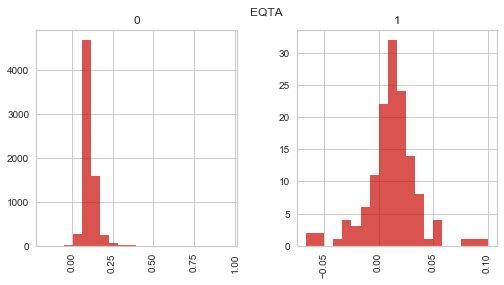

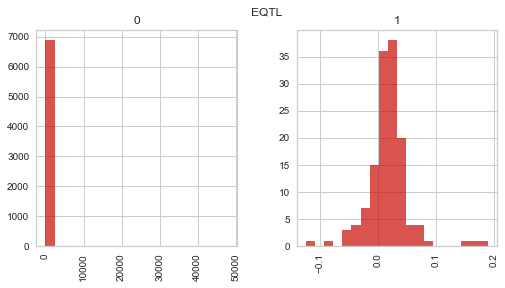

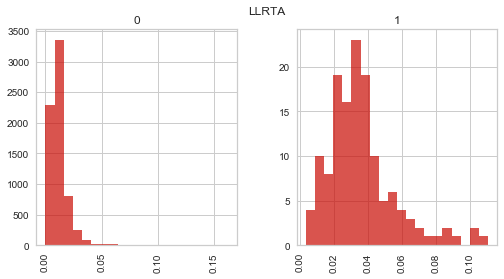

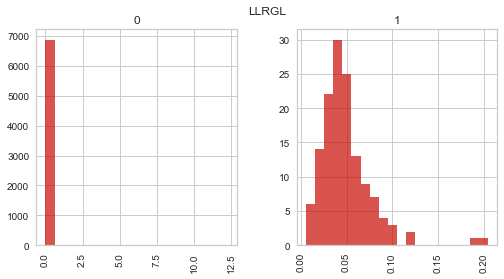

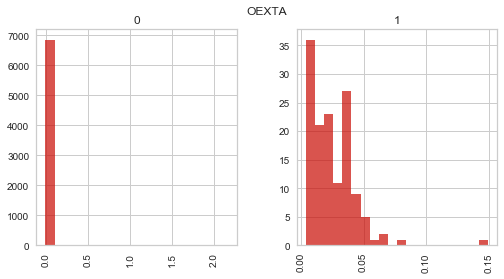

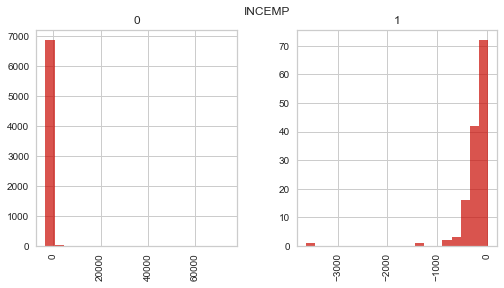

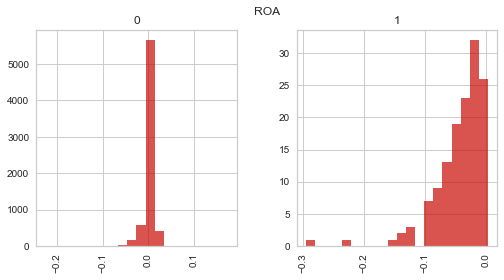

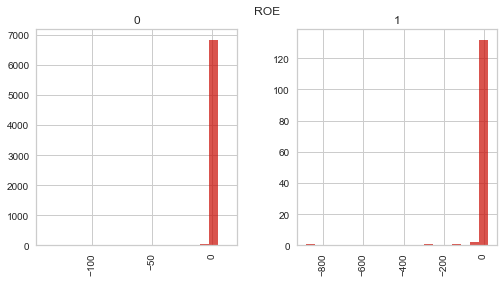

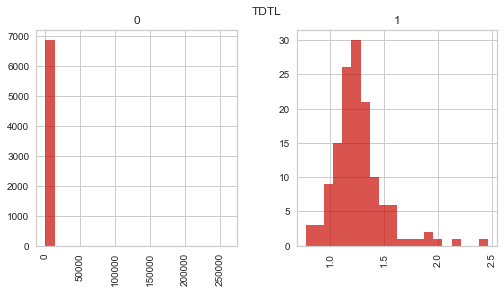

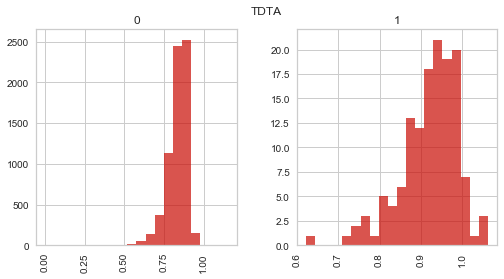

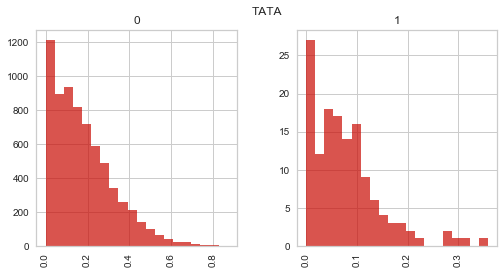

In [7]:
for col in camel_model_set.drop(columns=['AsOfDate', 'Target']).columns:
    camel_model_set[col].hist(by=camel_model_set['Target'],  bins=20, figsize=(8,4), alpha=0.7, color='r')
    plt.suptitle(col)
plt.show()

## Over-sampling with SMOTE

In [53]:
y = camel_model_set['Target']
X = camel_model_set.drop(['Target', 'AsOfDate'], axis=1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [55]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [56]:
print('Original dataset shape %s' % Counter(y_train))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_train_std_res, y_train_res = sm.fit_resample(X_train_std, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))
# Resampled dataset shape Counter({0: 900, 1: 900})

Original dataset shape Counter({0: 5501, 1: 110})
Resampled dataset shape Counter({0: 5501, 1: 5501})


## Traing various models 

In [72]:
models = {
    'log_reg' : LogisticRegression(C=1, solver='lbfgs'),
    'sgd_clf' : SGDClassifier(random_state=1),
    'gauss_nb' : GaussianNB(),
    'svm' : SVC(C=1, gamma='auto')
    
}

def fit_models(X, y):
    mfit = {model: models[model].fit(X, y)
           for model in models.keys()}
    
fit_models(X_train_std_res, y_train_res)

def obtain_predictions(X, y):
    predictions = {}
    for model in models.keys():
        predictions[str('pred_' + model)] = [models[model].predict(X)]
        
        return predictions

pred = obtain_predictions(X_test_std, y_test)
pred.keys()

dict_keys(['pred_log_reg'])

## In-sample classification with Logistic Regression

In [12]:
log_reg_res = LogisticRegression(solver='lbfgs')
log_reg_res.fit(X_train_std_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
log_reg_res_y_test_pred = log_reg_res.predict(X_test_std)
cf.report_classification_results(y_test, log_reg_res_y_test_pred)

Confusion Matrix :
[[1338   38]
 [   2   25]]
Accuracy Score : 0.9714896650035638
Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1376
           1       0.40      0.93      0.56        27

    accuracy                           0.97      1403
   macro avg       0.70      0.95      0.77      1403
weighted avg       0.99      0.97      0.98      1403



## Out-of-sample validation on 2011-Q3 data

In [14]:
camel_outofsample = pd.read_csv('data/camel_data_after2011Q3_OOS.csv', index_col = 0)
camel_validation_set = camel_outofsample.dropna()
len(camel_validation_set.loc[camel_validation_set.Target == 1])

18

In [15]:
y_oos = camel_validation_set['Target']
X_oos = camel_validation_set.drop(['Target', 'AsOfDate'], axis=1)
log_reg_res_pred = log_reg_res.predict(X_oos)
Counter(log_reg_res_pred)

Counter({0: 6583, 1: 46})

In [16]:
# To get the value of precision we divide the total number of correctly classified positive examples 
# by the total number of predicted positive examples. 
# High Precision indicates an example labeled as positive is indeed positive (small number of FP).

# Recall can be defined as the ratio of the total number of correctly classified positive 
# examples divide to the total number of positive examples. 
# High Recall indicates the class is correctly recognized (small number of FN).

# High recall, low precision:This means that most of the positive examples are correctly recognized (low FN) 
# but there are a lot of false positives. Low recall, high precision:This shows that we miss a lot 
# of positive examples (high FN) but those we predict as positive are indeed positive (low FP)

cf.report_classification_results(y_oos, log_reg_res_pred)

Confusion Matrix :
[[6565   46]
 [  18    0]]
Accuracy Score : 0.9903454518026852
Report : 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6611
           1       0.00      0.00      0.00        18

    accuracy                           0.99      6629
   macro avg       0.50      0.50      0.50      6629
weighted avg       0.99      0.99      0.99      6629



 ## In-sample classification Stocastic Gradient Desent 

In [21]:
sgd_clf_res = SGDClassifier(random_state=1)
sgd_clf_res.fit(X_train_std_res, y_train_res)

sgd_clf_y_train_res_pred = cross_val_predict(sgd_clf_res, X_train_std_res, y_train_res, cv=3)

In [22]:
sgd_clf_y_test_pred = cross_val_predict(sgd_clf_res, X_test_std, y_test, cv=3)

In [23]:
cf.report_classification_results(y_test, sgd_clf_y_test_pred)

Confusion Matrix :
[[1372    4]
 [  13   14]]
Accuracy Score : 0.9878831076265147
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1376
           1       0.78      0.52      0.62        27

    accuracy                           0.99      1403
   macro avg       0.88      0.76      0.81      1403
weighted avg       0.99      0.99      0.99      1403



In [80]:
# def plot_precision_recall(precisions, recalls, thresholds):
#     plt.plot(thresholds, precisions[: -1], 'b--', label='Precision')
#     plt.plot(thresholds, recalls[: -1], 'g-', label='Recall')
#     plt.xlabel('Threshold')
#     plt.legend(loc='center left')
#     plt.ylim([0,1])

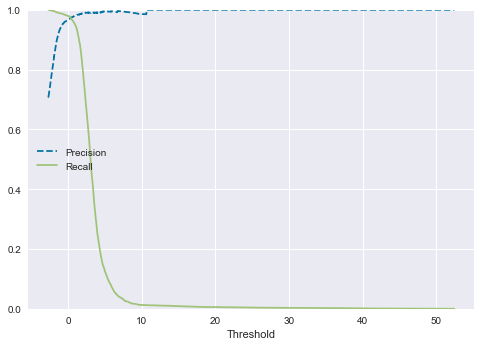

In [24]:
# Training
sgd_y_train_res_scores = cross_val_predict(sgd_clf_res, X_train_std_res, y_train_res, cv=3, method='decision_function')
sgd_train_precisions, sgd_train_recalls, sgd_train_thresholds = precision_recall_curve(y_train_res, sgd_y_train_res_scores)
cf.plot_precision_recall(sgd_train_precisions, sgd_train_recalls, sgd_train_thresholds)

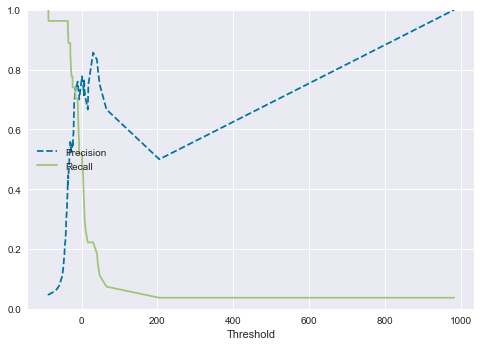

In [25]:
# Testing
sgd_y_test_res_scores = cross_val_predict(sgd_clf_res, X_test_std, y_test, cv=3, method='decision_function')
sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds = precision_recall_curve(y_test, sgd_y_test_res_scores)
cf.plot_precision_recall(sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds)

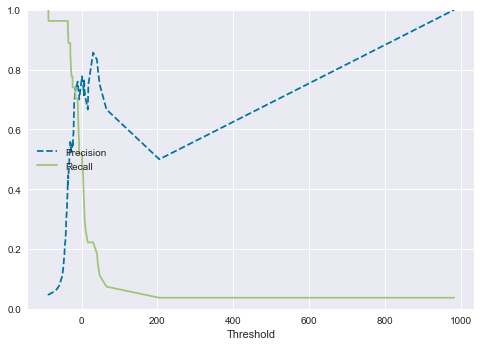

In [26]:
# Validation 
sgd_y_oos_res_scores = cross_val_predict(sgd_clf_res, X_oos, y_oos, cv=3, method='decision_function')
sgd_oos_precisions, sgd_oos_recalls, sgd_oos_thresholds = precision_recall_curve(y_oos, sgd_y_oos_res_scores)
cf.plot_precision_recall(sgd_test_precisions, sgd_test_recalls, sgd_test_thresholds)

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Negatove Rate')

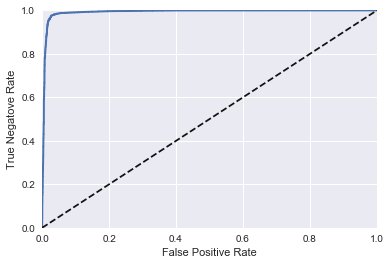

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_res, sgd_y_train_res_scores)
plot_roc_curve(fpr, tpr)

RecursionError: maximum recursion depth exceeded in comparison

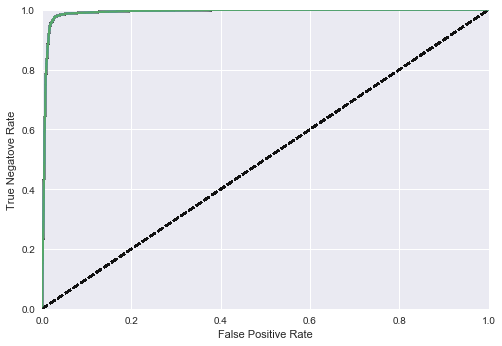

In [35]:
# Training
fpr, tpr, thresholds = roc_curve(y_train_res, sgd_y_train_res_scores)
cf.plot_roc_curve(fpr, tpr)

RecursionError: maximum recursion depth exceeded in comparison

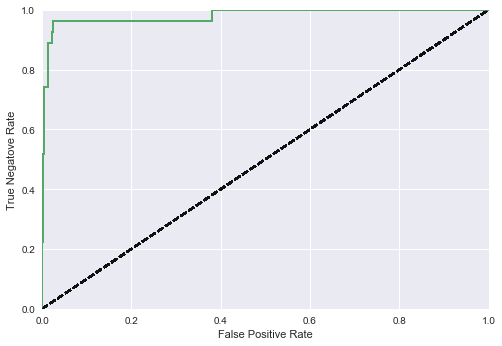

In [28]:
# Testing
sgd_y_test_res_scores = cross_val_predict(sgd_clf_res, X_test_std, y_test, cv=3, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_test, sgd_y_test_res_scores)
cf.plot_roc_curve(fpr, tpr)

RecursionError: maximum recursion depth exceeded in comparison

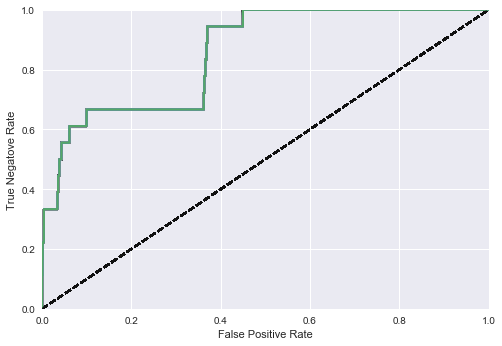

In [29]:
# Validation
sgd_y_oos_scores = cross_val_predict(sgd_clf_res, X_oos, y_oos, cv=3, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_oos, sgd_y_oos_scores)
cf.plot_roc_curve(fpr, tpr)

## Out-of-sample validation

In [32]:
sgd_clf_res_pred = sgd_clf_res.predict(X_oos)
confusion_matrix(y_oos, sgd_clf_res_pred)

array([[5655,  956],
       [   0,   18]])

In [33]:
cf.report_classification_results(y_oos, sgd_clf_res_pred)

Confusion Matrix :
[[5655  956]
 [   0   18]]
Accuracy Score : 0.8557851863026097
Report : 
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      6611
           1       0.02      1.00      0.04        18

    accuracy                           0.86      6629
   macro avg       0.51      0.93      0.48      6629
weighted avg       1.00      0.86      0.92      6629



## Deep out of sample validation

In [35]:
# Deep out of sample validation -- > out of sample validation on 2019 Q2 data

camel_outofsample2 = pd.read_csv('data/camel_data_after2019Q2_OOS.csv', index_col = 0)
camel_validation_set2 = camel_outofsample2.dropna()
len(camel_validation_set2.loc[camel_validation_set2.Target == 1])

1

In [36]:
y_oos2 = camel_validation_set2['Target']
X_oos2 = camel_validation_set2.drop(['Target', 'AsOfDate'], axis=1)
sgd_clf_res_pred2 = sgd_clf_res.predict(X_oos2)
Counter(sgd_clf_res_pred2)

Counter({0: 5025, 1: 169})

In [96]:
sgd_clf_res_pred2 = sgd_clf_res.predict(X_oos2)
confusion_matrix(y_oos2, sgd_clf_res_pred2)

array([[5024,  169],
       [   1,    0]])

In [37]:
classification_results_report(y_oos2, sgd_clf_res_pred2)

Confusion Matrix :
[[5024  169]
 [   1    0]]
Accuracy Score : 0.96726992683866
Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5193
           1       0.00      0.00      0.00         1

    accuracy                           0.97      5194
   macro avg       0.50      0.48      0.49      5194
weighted avg       1.00      0.97      0.98      5194

